# 06 Post-Deployment Analysis (MIT Timing + Proxy Lag)

**Purpose**  
Summarize MIT timing distributions and compare risk domains by timing while providing a cautious reporting-lag proxy.

**Outputs preserved:**
- `80_mit_timing_counts.png`
- `81_domain_by_timing_pct.csv`
- `82_reporting_lag_proxy_hist.png`

## Configuration

In [6]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = next((p for p in [Path.cwd(), *Path.cwd().parents] if (p / "src").exists()), Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.notebook_utils import ensure_output_dir, load_data

DATA_PATH = PROJECT_ROOT / "data"
OUTPUT_PATH = ensure_output_dir(PROJECT_ROOT / "outputs" / "figures")
TOP_N = 15
DATE_CANDIDATES = ["date_published", "date_submitted", "date_modified", "date_downloaded"]
REPORT_COLUMNS = ["url", "source_domain", "date_published", "date_submitted", "date_modified", "date_downloaded"]

loaded_tables = load_data(
    DATA_PATH,
    tables=["mit", "reports", "submissions"],
    reports_usecols=REPORT_COLUMNS,
)

mit_df = loaded_tables["mit"]
reports_df = loaded_tables["reports"]
submissions_df = loaded_tables["submissions"]

if reports_df is None or submissions_df is None:
    raise FileNotFoundError("Required tables missing: reports.csv or submissions.csv.")

print("MIT:", None if mit_df is None else mit_df.shape)
print("Reports:", reports_df.shape)
print("Submissions:", submissions_df.shape)

MIT: (1242, 8)
Reports: (6687, 6)
Submissions: (45, 15)


## Timing Distributions

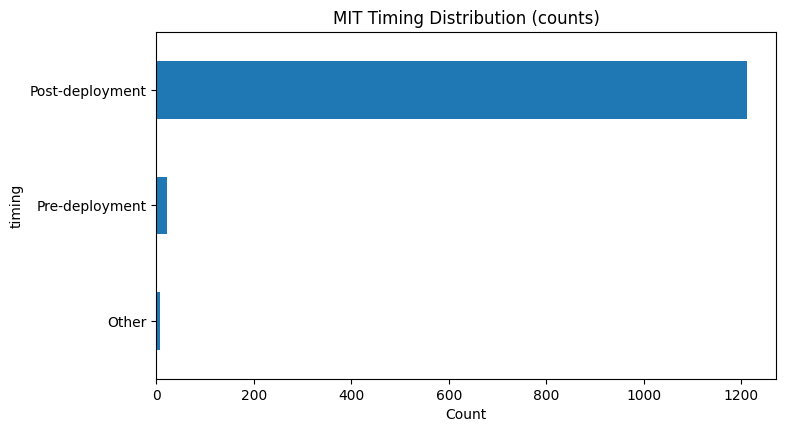

MIT Timing (%):


timing
Post-deployment    97.5
Pre-deployment      1.9
Other               0.6
Name: count, dtype: float64

In [7]:
if mit_df is None or "timing" not in mit_df.columns:
    print("MIT timing column not found.")
else:
    timing_counts = mit_df["timing"].dropna().astype(str).value_counts()
    fig, ax = plt.subplots(figsize=(8, 4.5))
    timing_counts.sort_values().plot(kind="barh", ax=ax)
    ax.set_title("MIT Timing Distribution (counts)")
    ax.set_xlabel("Count")
    fig.savefig(OUTPUT_PATH / "80_mit_timing_counts.png", bbox_inches="tight", dpi=200)
    plt.show()

    timing_pct = (timing_counts / timing_counts.sum() * 100).round(1)
    print("MIT Timing (%):")
    display(timing_pct)

In [8]:
if mit_df is not None and {"risk_domain", "timing"}.issubset(set(mit_df.columns)):
    timing_domain_df = mit_df.dropna(subset=["risk_domain", "timing"]).copy()
    timing_domain_df["risk_domain"] = timing_domain_df["risk_domain"].astype(str)
    timing_domain_df["timing"] = timing_domain_df["timing"].astype(str)

    top_domains = timing_domain_df["risk_domain"].value_counts().head(12).index
    timing_domain_df = timing_domain_df[timing_domain_df["risk_domain"].isin(top_domains)]

    domain_by_timing_pct = (pd.crosstab(timing_domain_df["timing"], timing_domain_df["risk_domain"], normalize="index") * 100).round(1)
    print("Risk domains by timing (% within timing):")
    display(domain_by_timing_pct)

    domain_by_timing_pct.to_csv(OUTPUT_PATH / "81_domain_by_timing_pct.csv")
else:
    print("MIT missing risk_domain or timing; skipping domain-by-timing.")

Risk domains by timing (% within timing):


risk_domain,1. Discrimination and Toxicity,2. Privacy & Security,3. Misinformation,4. Malicious Actors & Misuse,5. Human-Computer Interaction,6. Socioeconomic & Environmental Harms,"7. AI system safety, failures, and limitations"
timing,,,,,,,
Other,0.0,0.0,0.0,12.5,0.0,12.5,75.0
Post-deployment,18.7,7.3,13.0,34.6,2.6,1.3,22.3
Pre-deployment,13.0,26.1,4.3,17.4,4.3,8.7,26.1


## Reporting Lag Proxy

Lag proxy report date column: date_published_rep
Lag sample size: 0


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

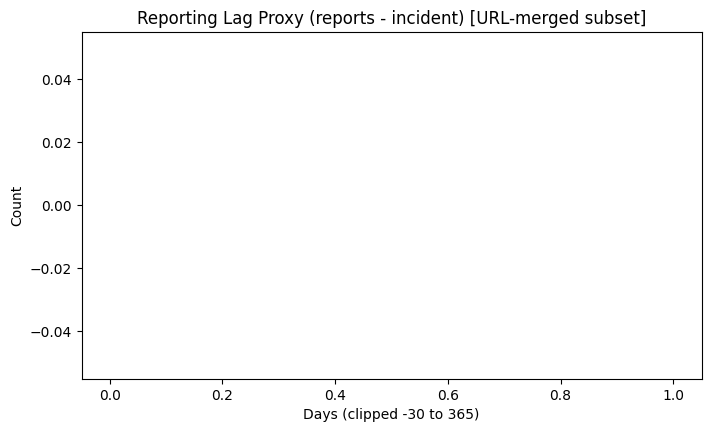

In [9]:
if "url" in submissions_df.columns and "url" in reports_df.columns:
    merged_df = submissions_df.merge(reports_df, on="url", how="inner", suffixes=("_sub", "_rep"))

    merged_df["_incident_dt"] = pd.to_datetime(merged_df.get("incident_date"), errors="coerce", utc=True).dt.tz_convert(None)

    report_date_candidates = [
        "date_published_rep", "date_published",
        "date_submitted_rep", "date_submitted",
        "date_modified_rep", "date_modified",
        "date_downloaded_rep", "date_downloaded",
    ]
    lag_report_date_col = next((c for c in report_date_candidates if c in merged_df.columns), None)
    print("Lag proxy report date column:", lag_report_date_col)

    if lag_report_date_col is None:
        print("No report date column found after merge. Date-like columns:", [c for c in merged_df.columns if "date" in c])
    else:
        merged_df["_published_dt"] = pd.to_datetime(merged_df[lag_report_date_col], errors="coerce", utc=True).dt.tz_convert(None)
        lag_days = (merged_df["_published_dt"] - merged_df["_incident_dt"]).dt.days.dropna()

        print("Lag sample size:", len(lag_days))
        display(lag_days.describe())

        fig, ax = plt.subplots(figsize=(8, 4.5))
        lag_days.clip(lower=-30, upper=365).plot(kind="hist", bins=40, ax=ax)
        ax.set_title("Reporting Lag Proxy (reports - incident) [URL-merged subset]")
        ax.set_xlabel("Days (clipped -30 to 365)")
        ax.set_ylabel("Count")
        fig.savefig(OUTPUT_PATH / "82_reporting_lag_proxy_hist.png", bbox_inches="tight", dpi=200)
        plt.show()
else:
    print("Missing url in submissions or reports; skipping lag proxy.")

## Notes and Limitations

- MIT timing interpretations depend on taxonomy annotation quality.
- Lag uses URL-merged subset only; it is intentionally presented as a proxy.
- Defensive checks preserve runtime stability under schema variation.